In [1]:
# Setup Awal
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, models, transforms
from torchvision.transforms import RandAugment
import time
import copy
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Config
torch.manual_seed(42)
np.random.seed(42)
batch_size = 32
learning_rate = 0.001
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

# Direktori dataset
train_dir = 'C:/Users/ASUS/Downloads/Dataset Manual/train'
val_dir = 'C:/Users/ASUS/Downloads/Dataset Manual/val'

Menggunakan device: cuda


In [2]:
# Data Preprocessing
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'aug': transforms.Compose([
        RandAugment(num_ops=2, magnitude=9),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_dataset_base = datasets.ImageFolder(train_dir, data_transforms['train'])
train_dataset_aug  = datasets.ImageFolder(train_dir, data_transforms['aug'])
train_dataset_concat = ConcatDataset([train_dataset_base, train_dataset_aug])

# Load dataset
image_datasets = {
    'train': train_dataset_concat,
    'val': datasets.ImageFolder(val_dir, data_transforms['val'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
num_classes = image_datasets['train'].datasets[0].classes

print(f"Class names: {num_classes}")
print(f"Jumlah kelas: {len(num_classes)}")
print(f"Ukuran dataset - train : {dataset_sizes['train']}, val: {dataset_sizes['val']}")

Class names: ['Acalypha siamensis Oliv. ex Gage', 'Acalypha wilkesiana Müll.Arg', 'Agathis borneensis Warburg', 'Agave demeesteriana Jacobi', 'Allamanda cathartica L', 'Alocasia macrorrhizos', 'Aloe vera (L.) Burm.f', 'Alstonia angustiloba Miq', 'Alstonia iwahigensis Elmer', 'Amorphophallus paeoniifolius (Dennst.) Nicolson', 'Asystasia gangetica (L.) T.Anderson', 'Borassodendron borneensis J. Dransf', 'Bougainvillea spectabilis', 'Cocos nucifera L', 'Codiaeum variegatum (L.) Rumph. ex A.Juss', 'Cordyline fruticosa (L.) A. Chev', 'Cornus alba L', 'Costus woodsonii Maas', 'Ctenanthe burle-marxii H.Kenn', 'Dillenia sp', 'Diospyros borneensis Hiern', 'Diospyros confertiflora Hiern', 'Dracaena reflexa Lam', 'Dracaena trifasciata (Prain) Mabb', 'Duranta erecta L', 'Eusideroxylon zwageri Teijsm. & Binn', 'Excoecaria cochinchinensis Lour', 'Furcraea foetida (L.) Haw', 'Garcinia mangostana L', 'Grammatophyllum speciosum', 'Hibiscus rosa-sinensis L', 'Hopea pedicellata (Brandis) Symington', 'Hur

In [3]:
# Fungsi Inisialisasi Model
from torchvision.models import ResNet50_Weights, MobileNet_V3_Large_Weights, DenseNet121_Weights, ConvNeXt_Tiny_Weights

def initialize_model(model_name, scenario):
    model = None

    if model_name == 'ResNet50':
        model = models.resnet50(weights='IMAGENET1K_V1')
        if scenario == 'no_hidden':
            model.fc = nn.Linear(model.fc.in_features, len(num_classes))
        else:
            model.fc = nn.Sequential(
                nn.Linear(model.fc.in_features, 512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, len(num_classes))
            )
        # Freeze semua layer kecuali fc
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True

    elif model_name == 'DenseNet121':
        model = models.densenet121(weights='IMAGENET1K_V1')
        if scenario == 'no_hidden':
            model.classifier = nn.Linear(model.classifier.in_features, len(num_classes))
        else:
            model.classifier = nn.Sequential(
                nn.Linear(model.classifier.in_features, 512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, len(num_classes))
            )
        # Freeze semua layer kecuali classifier
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True
                
    elif model_name == 'MobileNetV3':
        model = models.mobilenet_v3_large(weights='IMAGENET1K_V1')
        if scenario == 'no_hidden':
            model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(num_classes))
        else:
            model.classifier[-1] = nn.Sequential(
                nn.Linear(model.classifier[-1].in_features, 512),
                nn.Hardswish(),
                nn.Dropout(0.5),
                nn.Linear(512, len(num_classes))
            )
        # Freeze semua layer kecuali classifier
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True

    elif model_name == 'ConvNeXt':
        model = models.convnext_tiny(weights='IMAGENET1K_V1')
        if scenario == 'no_hidden':
            model.classifier = nn.Sequential(
                nn.Flatten(1),
                nn.LayerNorm([model.classifier[-1].in_features], eps=1e-6),
                nn.Linear(model.classifier[-1].in_features, len(num_classes))
            )
        else:
            model.classifier = nn.Sequential(
                nn.Flatten(1),
                nn.LayerNorm([model.classifier[-1].in_features], eps=1e-6),
                nn.Linear(model.classifier[-1].in_features, 512),
                nn.GELU(),
                nn.Dropout(0.5),
                nn.Linear(512, len(num_classes))
            )
        # Freeze semua layer kecuali classifier
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True

    return model.to(device)

In [4]:
# Fungsi Train&Val
def train_model(model, model_name, scenario):
    print(f'\n=== Model: {model_name} | Skenario: {scenario} ===\n')
    since = time.time()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1} / {num_epochs}')
        print('-' * 10)
        eptm = time.time()
        
        # Training Phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        train_preds, train_targets = [], []

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()
            
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())
            
        # Hitung semua metrik
        epoch_train_loss = running_loss / len(image_datasets['train'])
        epoch_train_acc = 100 * correct_train / total_train
        epoch_train_f1 = f1_score(train_targets, train_preds, average='macro')

        # Validation Phase
        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0
        val_preds, val_targets = [], []

        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                
                _, preds = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()
                
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        # Hitung semua metrik
        epoch_val_loss = val_running_loss / len(image_datasets['val'])
        epoch_val_acc = 100 * correct_val / total_val
        epoch_val_f1 = f1_score(val_targets, val_preds, average='macro')

        # Update history
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['train_f1'].append(epoch_train_f1)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['val_f1'].append(epoch_val_f1)

        # Simpan model terbaik
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        if epoch_val_f1 > best_f1:
            best_f1 = epoch_val_f1
        
        epoch_time = time.time() - eptm
        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} F1: {epoch_train_f1:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}% F1: {epoch_val_f1:.4f} | '
              f'Epoch time: {epoch_time // 60:.0f}m {epoch_time % 60:.0f}s\n')
        
    time_elapsed = time.time() - since
    print(f'Training {model_name} {scenario} complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    print(f'Best val F1: {best_f1:4f}\n')
    visualize_training(history)

    # Save model
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), f'C:/Users/ASUS/Coding/Jupiter/PRTA/{model_name}_{scenario}.pth')

    return {
        'model_name': model_name,
        'scenario': scenario,
        'train_time': time_elapsed,
        'history': history
    }


def visualize_training(history):
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='train')
    plt.plot(history['val_loss'], label='val')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='train')
    plt.plot(history['val_acc'], label='val')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot F1-score
    plt.subplot(1, 3, 3)
    plt.plot(history['val_f1'], label='val')
    plt.title('Validation F1-score over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.legend()

    plt.tight_layout()
    plt.show()

    
# Menyimpan hasil training
results_training = []


=== Model: ResNet50 | Skenario: no_hidden ===

Epoch 1 / 50
----------
Train Loss: 1.9891 Acc: 55.9615 F1: 0.5574 | Val Loss: 0.8245 Acc: 80.4808% F1: 0.7987 | Epoch time: 1m 19s

Epoch 2 / 50
----------
Train Loss: 0.8875 Acc: 79.7596 F1: 0.7969 | Val Loss: 0.6312 Acc: 83.0288% F1: 0.8183 | Epoch time: 1m 17s

Epoch 3 / 50
----------
Train Loss: 0.7013 Acc: 81.8910 F1: 0.8181 | Val Loss: 0.5152 Acc: 86.2019% F1: 0.8539 | Epoch time: 1m 17s

Epoch 4 / 50
----------
Train Loss: 0.5899 Acc: 84.1026 F1: 0.8406 | Val Loss: 0.4633 Acc: 86.3462% F1: 0.8622 | Epoch time: 1m 17s

Epoch 5 / 50
----------
Train Loss: 0.5302 Acc: 85.3526 F1: 0.8533 | Val Loss: 0.4992 Acc: 85.7692% F1: 0.8549 | Epoch time: 1m 17s

Epoch 6 / 50
----------
Train Loss: 0.5105 Acc: 85.7212 F1: 0.8567 | Val Loss: 0.4285 Acc: 87.8365% F1: 0.8752 | Epoch time: 1m 17s

Epoch 7 / 50
----------
Train Loss: 0.5098 Acc: 85.8974 F1: 0.8588 | Val Loss: 0.4361 Acc: 87.4519% F1: 0.8725 | Epoch time: 1m 17s

Epoch 8 / 50
--------

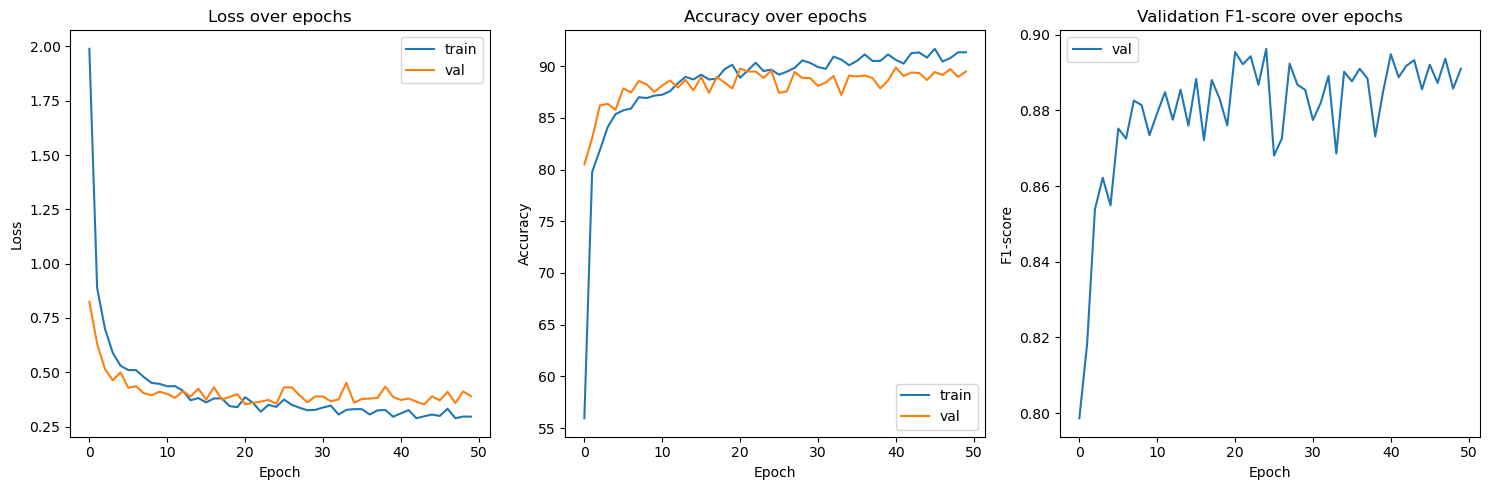


=== Model: ResNet50 | Skenario: with_hidden ===

Epoch 1 / 50
----------
Train Loss: 2.8426 Acc: 28.5737 F1: 0.2750 | Val Loss: 1.3708 Acc: 70.0962% F1: 0.6737 | Epoch time: 1m 17s

Epoch 2 / 50
----------
Train Loss: 1.6249 Acc: 55.4327 F1: 0.5435 | Val Loss: 0.8307 Acc: 79.4231% F1: 0.7789 | Epoch time: 1m 17s

Epoch 3 / 50
----------
Train Loss: 1.3125 Acc: 62.7404 F1: 0.6216 | Val Loss: 0.6823 Acc: 81.6827% F1: 0.8026 | Epoch time: 1m 17s

Epoch 4 / 50
----------
Train Loss: 1.1866 Acc: 66.4583 F1: 0.6600 | Val Loss: 0.6403 Acc: 82.2596% F1: 0.8164 | Epoch time: 1m 17s

Epoch 5 / 50
----------
Train Loss: 1.1031 Acc: 68.7340 F1: 0.6835 | Val Loss: 0.5412 Acc: 84.9519% F1: 0.8432 | Epoch time: 1m 17s

Epoch 6 / 50
----------
Train Loss: 1.0320 Acc: 70.4006 F1: 0.7000 | Val Loss: 0.5518 Acc: 84.4231% F1: 0.8372 | Epoch time: 1m 17s

Epoch 7 / 50
----------
Train Loss: 0.9905 Acc: 71.2821 F1: 0.7102 | Val Loss: 0.5055 Acc: 85.4808% F1: 0.8499 | Epoch time: 1m 17s

Epoch 8 / 50
------

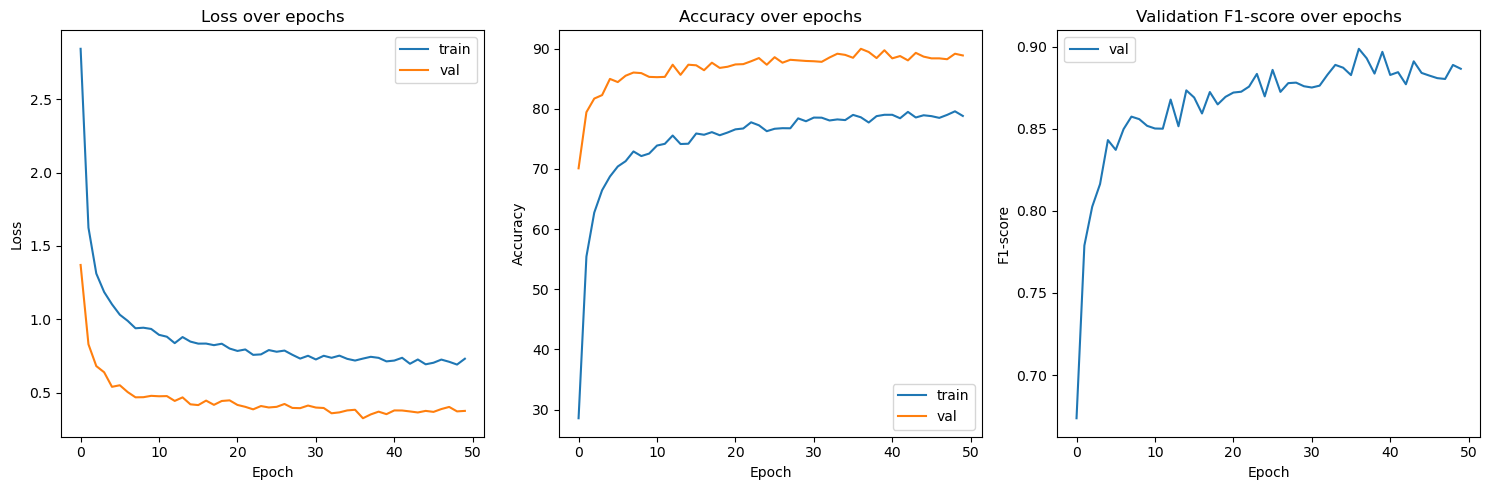

In [5]:
# ResNet50
#Tanpa Hidden Layer
model = initialize_model('ResNet50', 'no_hidden')
res = train_model(model, 'ResNet50', 'no_hidden')
results_training.append(res)

#Dengan Hidden Layer
model = initialize_model('ResNet50', 'with_hidden')
res = train_model(model, 'ResNet50', 'with_hidden')
results_training.append(res)


=== Model: DenseNet121 | Skenario: no_hidden ===

Epoch 1 / 50
----------
Train Loss: 2.4079 Acc: 49.7115 F1: 0.4910 | Val Loss: 1.2147 Acc: 76.5385% F1: 0.7561 | Epoch time: 1m 20s

Epoch 2 / 50
----------
Train Loss: 1.1363 Acc: 77.9968 F1: 0.7776 | Val Loss: 0.7699 Acc: 82.5481% F1: 0.8164 | Epoch time: 1m 19s

Epoch 3 / 50
----------
Train Loss: 0.8360 Acc: 82.7083 F1: 0.8263 | Val Loss: 0.6055 Acc: 86.0577% F1: 0.8538 | Epoch time: 1m 19s

Epoch 4 / 50
----------
Train Loss: 0.7010 Acc: 84.0224 F1: 0.8398 | Val Loss: 0.5516 Acc: 85.9135% F1: 0.8546 | Epoch time: 1m 19s

Epoch 5 / 50
----------
Train Loss: 0.6083 Acc: 85.3686 F1: 0.8536 | Val Loss: 0.5061 Acc: 86.5385% F1: 0.8663 | Epoch time: 1m 19s

Epoch 6 / 50
----------
Train Loss: 0.5599 Acc: 86.1699 F1: 0.8610 | Val Loss: 0.4745 Acc: 87.7404% F1: 0.8753 | Epoch time: 1m 19s

Epoch 7 / 50
----------
Train Loss: 0.5107 Acc: 87.9167 F1: 0.8790 | Val Loss: 0.4494 Acc: 87.7404% F1: 0.8765 | Epoch time: 1m 19s

Epoch 8 / 50
-----

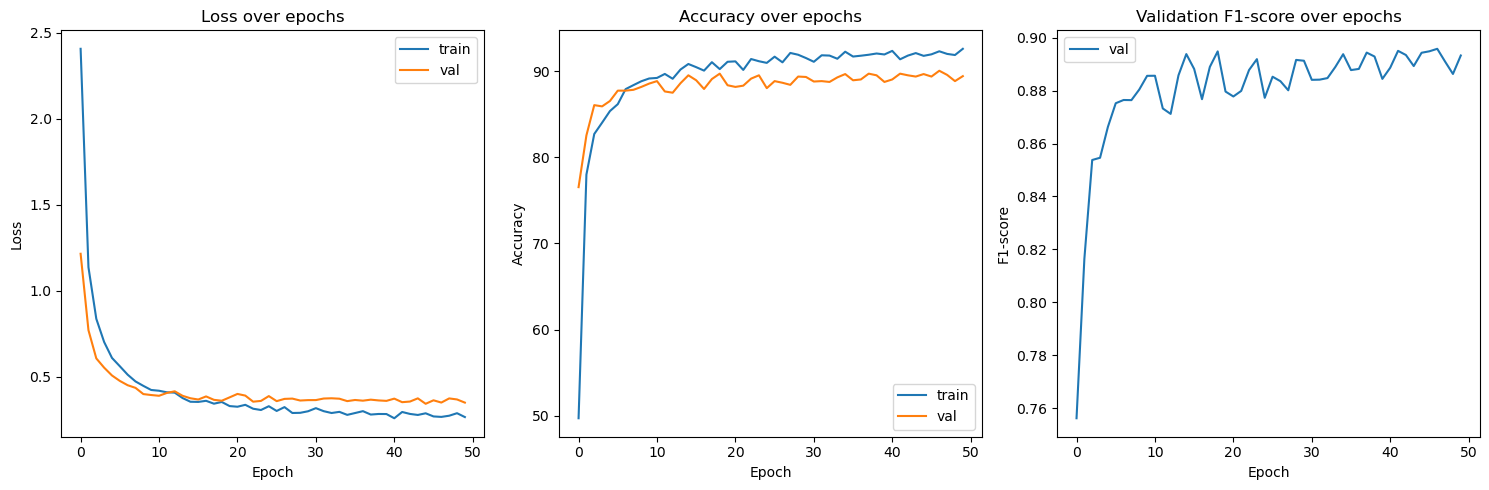


=== Model: DenseNet121 | Skenario: with_hidden ===

Epoch 1 / 50
----------
Train Loss: 2.6814 Acc: 34.1026 F1: 0.3304 | Val Loss: 1.2592 Acc: 72.3558% F1: 0.6963 | Epoch time: 1m 19s

Epoch 2 / 50
----------
Train Loss: 1.3908 Acc: 63.0288 F1: 0.6236 | Val Loss: 0.7466 Acc: 81.4904% F1: 0.8120 | Epoch time: 1m 19s

Epoch 3 / 50
----------
Train Loss: 1.0649 Acc: 70.8494 F1: 0.7043 | Val Loss: 0.6103 Acc: 83.0769% F1: 0.8252 | Epoch time: 1m 19s

Epoch 4 / 50
----------
Train Loss: 0.9399 Acc: 73.7821 F1: 0.7351 | Val Loss: 0.5244 Acc: 84.8077% F1: 0.8434 | Epoch time: 1m 19s

Epoch 5 / 50
----------
Train Loss: 0.8523 Acc: 75.6571 F1: 0.7549 | Val Loss: 0.4937 Acc: 85.9615% F1: 0.8524 | Epoch time: 1m 19s

Epoch 6 / 50
----------
Train Loss: 0.8161 Acc: 76.9872 F1: 0.7682 | Val Loss: 0.4523 Acc: 86.3462% F1: 0.8630 | Epoch time: 1m 19s

Epoch 7 / 50
----------
Train Loss: 0.7686 Acc: 77.5321 F1: 0.7741 | Val Loss: 0.4529 Acc: 87.1635% F1: 0.8688 | Epoch time: 1m 19s

Epoch 8 / 50
---

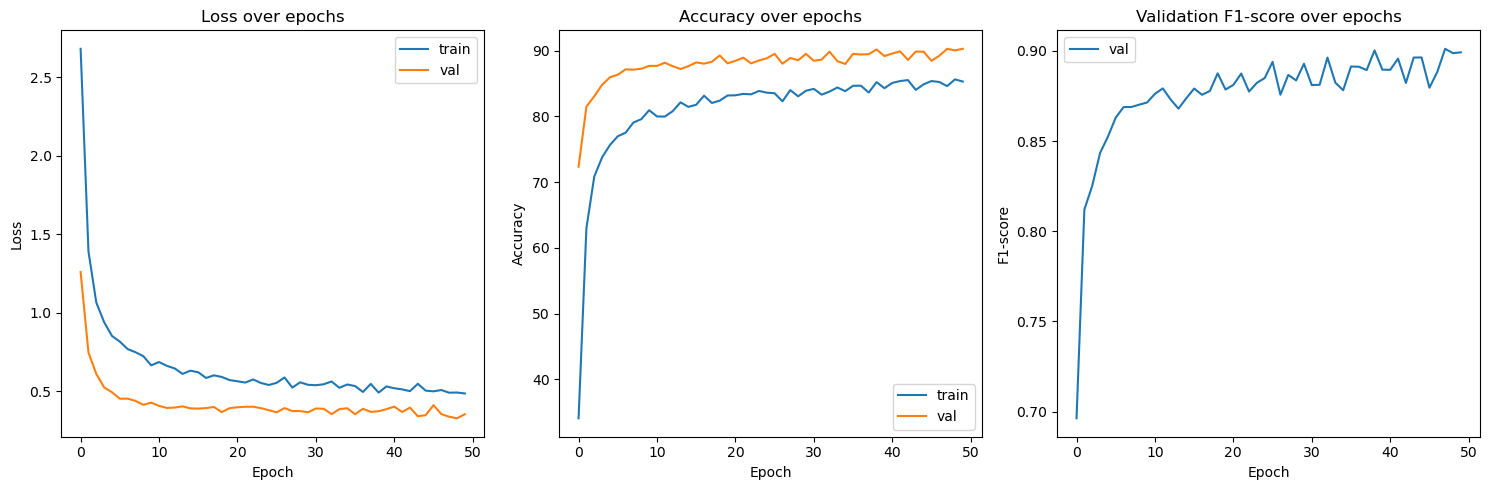

In [6]:
# DenseNet121
#Tanpa Hidden Layer
model = initialize_model('DenseNet121', 'no_hidden')
res = train_model(model, 'DenseNet121', 'no_hidden')
results_training.append(res)

#Dengan Hidden Layer
model = initialize_model('DenseNet121', 'with_hidden')
res = train_model(model, 'DenseNet121', 'with_hidden')
results_training.append(res)


=== Model: MobileNetV3 | Skenario: no_hidden ===

Epoch 1 / 50
----------
Train Loss: 1.2751 Acc: 67.0353 F1: 0.6687 | Val Loss: 0.6006 Acc: 82.0673% F1: 0.8157 | Epoch time: 0m 49s

Epoch 2 / 50
----------
Train Loss: 0.5866 Acc: 83.6058 F1: 0.8354 | Val Loss: 0.5521 Acc: 85.0962% F1: 0.8496 | Epoch time: 0m 48s

Epoch 3 / 50
----------
Train Loss: 0.5100 Acc: 85.2564 F1: 0.8523 | Val Loss: 0.4597 Acc: 85.2885% F1: 0.8513 | Epoch time: 0m 48s

Epoch 4 / 50
----------
Train Loss: 0.4529 Acc: 86.3622 F1: 0.8632 | Val Loss: 0.4564 Acc: 87.0192% F1: 0.8636 | Epoch time: 0m 49s

Epoch 5 / 50
----------
Train Loss: 0.4020 Acc: 88.1891 F1: 0.8819 | Val Loss: 0.4619 Acc: 86.3462% F1: 0.8593 | Epoch time: 0m 48s

Epoch 6 / 50
----------
Train Loss: 0.3818 Acc: 88.7821 F1: 0.8875 | Val Loss: 0.4621 Acc: 87.2115% F1: 0.8666 | Epoch time: 0m 48s

Epoch 7 / 50
----------
Train Loss: 0.3630 Acc: 89.2949 F1: 0.8929 | Val Loss: 0.3981 Acc: 88.2692% F1: 0.8808 | Epoch time: 0m 48s

Epoch 8 / 50
-----

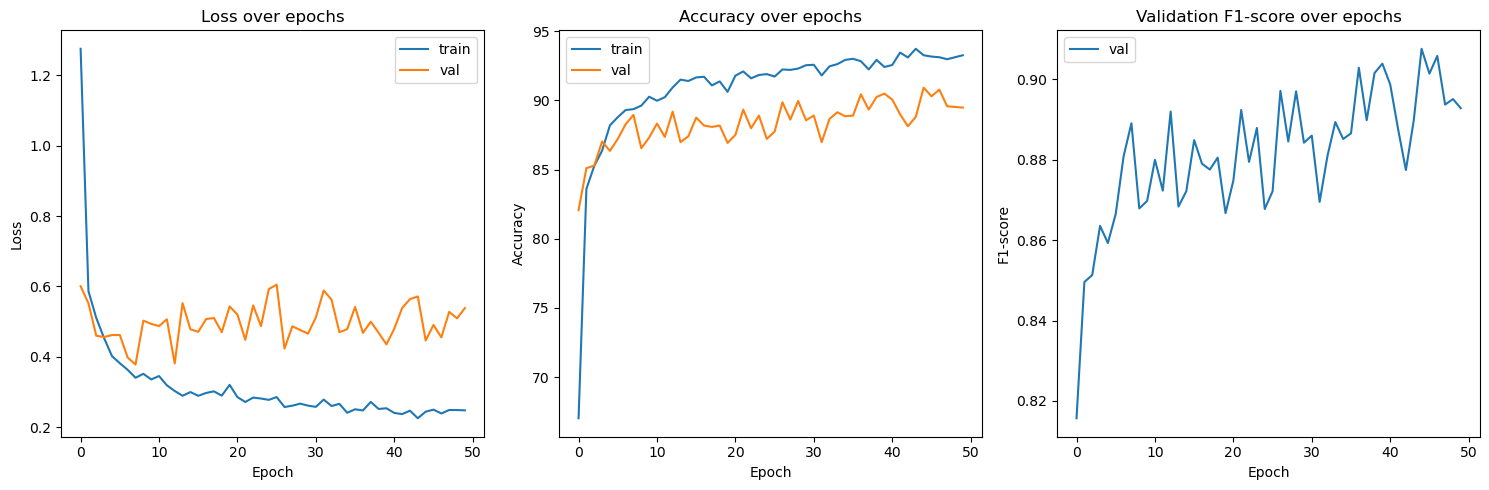


=== Model: MobileNetV3 | Skenario: with_hidden ===

Epoch 1 / 50
----------
Train Loss: 1.5400 Acc: 59.5032 F1: 0.5898 | Val Loss: 0.6328 Acc: 80.1442% F1: 0.7909 | Epoch time: 0m 48s

Epoch 2 / 50
----------
Train Loss: 0.7719 Acc: 77.8045 F1: 0.7770 | Val Loss: 0.5264 Acc: 83.8942% F1: 0.8381 | Epoch time: 0m 48s

Epoch 3 / 50
----------
Train Loss: 0.6094 Acc: 82.4679 F1: 0.8240 | Val Loss: 0.5445 Acc: 84.0865% F1: 0.8372 | Epoch time: 0m 48s

Epoch 4 / 50
----------
Train Loss: 0.5581 Acc: 83.0769 F1: 0.8302 | Val Loss: 0.5188 Acc: 85.1923% F1: 0.8513 | Epoch time: 0m 48s

Epoch 5 / 50
----------
Train Loss: 0.5346 Acc: 84.5833 F1: 0.8457 | Val Loss: 0.5411 Acc: 85.7212% F1: 0.8519 | Epoch time: 0m 48s

Epoch 6 / 50
----------
Train Loss: 0.4824 Acc: 85.9135 F1: 0.8589 | Val Loss: 0.5066 Acc: 86.5865% F1: 0.8593 | Epoch time: 0m 48s

Epoch 7 / 50
----------
Train Loss: 0.4657 Acc: 86.3622 F1: 0.8634 | Val Loss: 0.4566 Acc: 87.8365% F1: 0.8775 | Epoch time: 0m 48s

Epoch 8 / 50
---

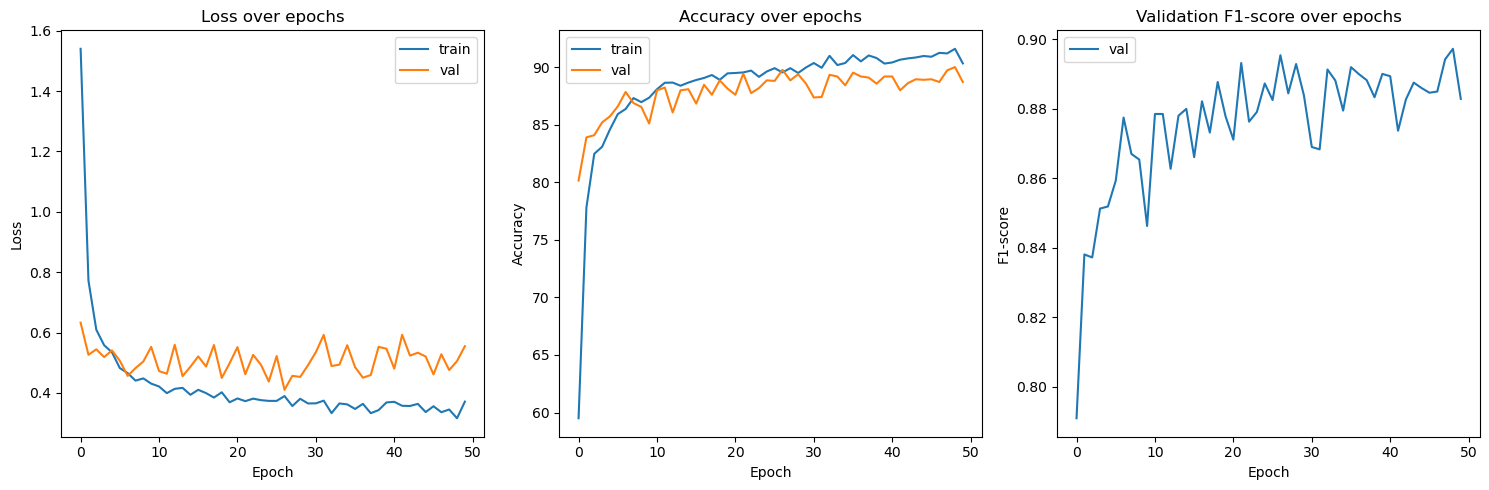

In [7]:
# MobileNetV3 Large
#Tanpa Hidden Layer
model = initialize_model('MobileNetV3', 'no_hidden')
res = train_model(model, 'MobileNetV3', 'no_hidden')
results_training.append(res)

#Dengan Hidden Layer
model = initialize_model('MobileNetV3', 'with_hidden')
res = train_model(model, 'MobileNetV3', 'with_hidden')
results_training.append(res)


=== Model: ConvNeXt | Skenario: no_hidden ===

Epoch 1 / 50
----------
Train Loss: 1.4300 Acc: 69.6635 F1: 0.6953 | Val Loss: 0.5966 Acc: 85.1923% F1: 0.8488 | Epoch time: 1m 38s

Epoch 2 / 50
----------
Train Loss: 0.5242 Acc: 88.1090 F1: 0.8804 | Val Loss: 0.4345 Acc: 88.4615% F1: 0.8789 | Epoch time: 1m 37s

Epoch 3 / 50
----------
Train Loss: 0.3669 Acc: 91.3942 F1: 0.9140 | Val Loss: 0.3836 Acc: 89.3750% F1: 0.8942 | Epoch time: 1m 37s

Epoch 4 / 50
----------
Train Loss: 0.2986 Acc: 92.4359 F1: 0.9243 | Val Loss: 0.3166 Acc: 90.9135% F1: 0.9068 | Epoch time: 1m 37s

Epoch 5 / 50
----------
Train Loss: 0.2601 Acc: 93.0449 F1: 0.9304 | Val Loss: 0.3228 Acc: 90.9135% F1: 0.9075 | Epoch time: 1m 37s

Epoch 6 / 50
----------
Train Loss: 0.2280 Acc: 94.3590 F1: 0.9435 | Val Loss: 0.3300 Acc: 89.9519% F1: 0.9011 | Epoch time: 1m 37s

Epoch 7 / 50
----------
Train Loss: 0.2142 Acc: 94.2468 F1: 0.9425 | Val Loss: 0.2735 Acc: 92.0192% F1: 0.9190 | Epoch time: 1m 37s

Epoch 8 / 50
--------

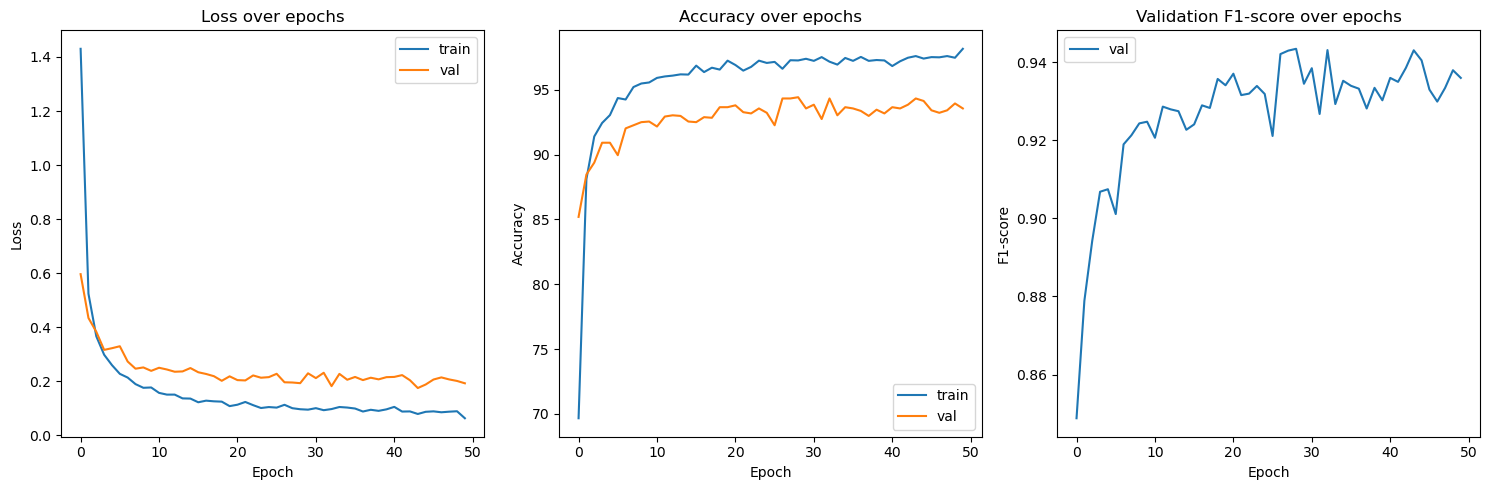


=== Model: ConvNeXt | Skenario: with_hidden ===

Epoch 1 / 50
----------
Train Loss: 1.3713 Acc: 64.0705 F1: 0.6422 | Val Loss: 0.5886 Acc: 81.6827% F1: 0.8123 | Epoch time: 1m 37s

Epoch 2 / 50
----------
Train Loss: 0.5376 Acc: 84.3109 F1: 0.8427 | Val Loss: 0.4126 Acc: 87.6923% F1: 0.8774 | Epoch time: 1m 37s

Epoch 3 / 50
----------
Train Loss: 0.3972 Acc: 88.2372 F1: 0.8823 | Val Loss: 0.3032 Acc: 90.8173% F1: 0.9080 | Epoch time: 1m 37s

Epoch 4 / 50
----------
Train Loss: 0.3390 Acc: 89.9359 F1: 0.8994 | Val Loss: 0.2929 Acc: 91.1538% F1: 0.9087 | Epoch time: 1m 37s

Epoch 5 / 50
----------
Train Loss: 0.3032 Acc: 90.9135 F1: 0.9088 | Val Loss: 0.3133 Acc: 90.3365% F1: 0.9008 | Epoch time: 1m 37s

Epoch 6 / 50
----------
Train Loss: 0.2732 Acc: 91.9391 F1: 0.9194 | Val Loss: 0.2918 Acc: 91.5865% F1: 0.9137 | Epoch time: 1m 37s

Epoch 7 / 50
----------
Train Loss: 0.2547 Acc: 92.0513 F1: 0.9204 | Val Loss: 0.2968 Acc: 90.8173% F1: 0.9078 | Epoch time: 1m 37s

Epoch 8 / 50
------

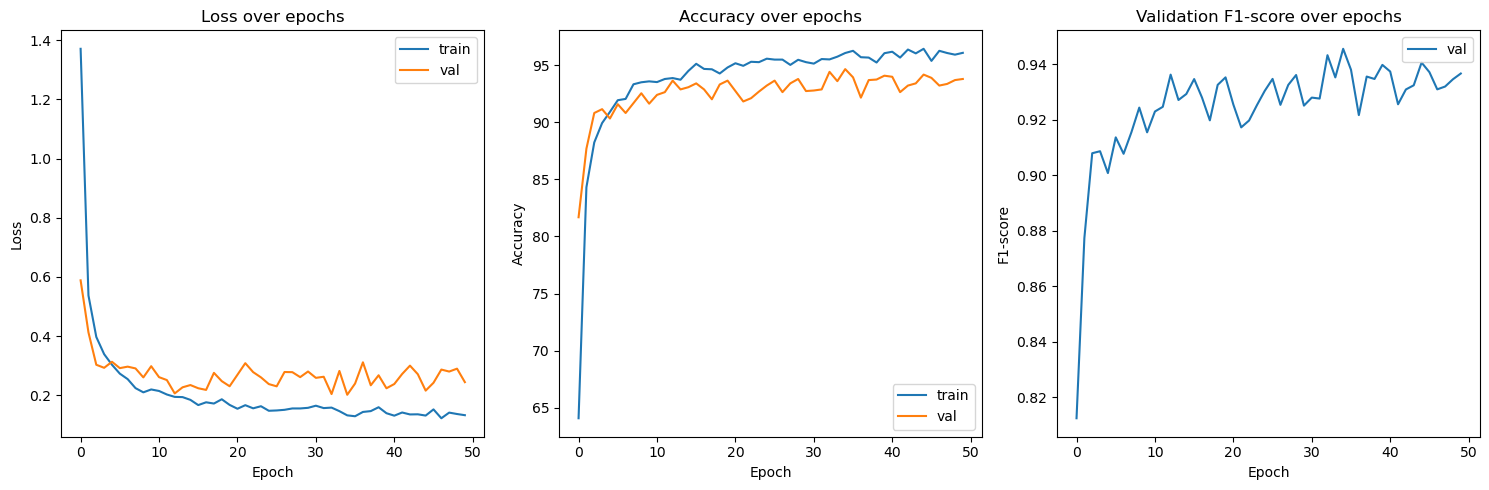

In [8]:
# ConvNeXt Tiny
#Tanpa Hidden Layer
model = initialize_model('ConvNeXt', 'no_hidden')
res = train_model(model, 'ConvNeXt', 'no_hidden')
results_training.append(res)

#Dengan Hidden Layer
model = initialize_model('ConvNeXt', 'with_hidden')
res = train_model(model, 'ConvNeXt', 'with_hidden')
results_training.append(res)

In [9]:
# Simpan hasil train & val
results_training_df = pd.DataFrame(results_training)
results_training_df.to_csv('C:/Users/ASUS/Coding/Jupiter/PRTA/train&val_results.csv', index=False)
print(results_training_df)

    model_name     scenario   train_time  \
0     ResNet50    no_hidden  3853.677625   
1     ResNet50  with_hidden  3851.986614   
2  DenseNet121    no_hidden  3960.739840   
3  DenseNet121  with_hidden  3956.862639   
4  MobileNetV3    no_hidden  2410.718405   
5  MobileNetV3  with_hidden  2418.936737   
6     ConvNeXt    no_hidden  4839.490314   
7     ConvNeXt  with_hidden  4851.997531   

                                             history  
0  {'train_loss': [1.9890723751141475, 0.88753844...  
1  {'train_loss': [2.8426070506756123, 1.62487917...  
2  {'train_loss': [2.4078882137934365, 1.13630894...  
3  {'train_loss': [2.68141502172519, 1.3908289111...  
4  {'train_loss': [1.2750723652350597, 0.58657314...  
5  {'train_loss': [1.5399538055444375, 0.77191376...  
6  {'train_loss': [1.4300443236644451, 0.52421292...  
7  {'train_loss': [1.3713347415129344, 0.53756087...  


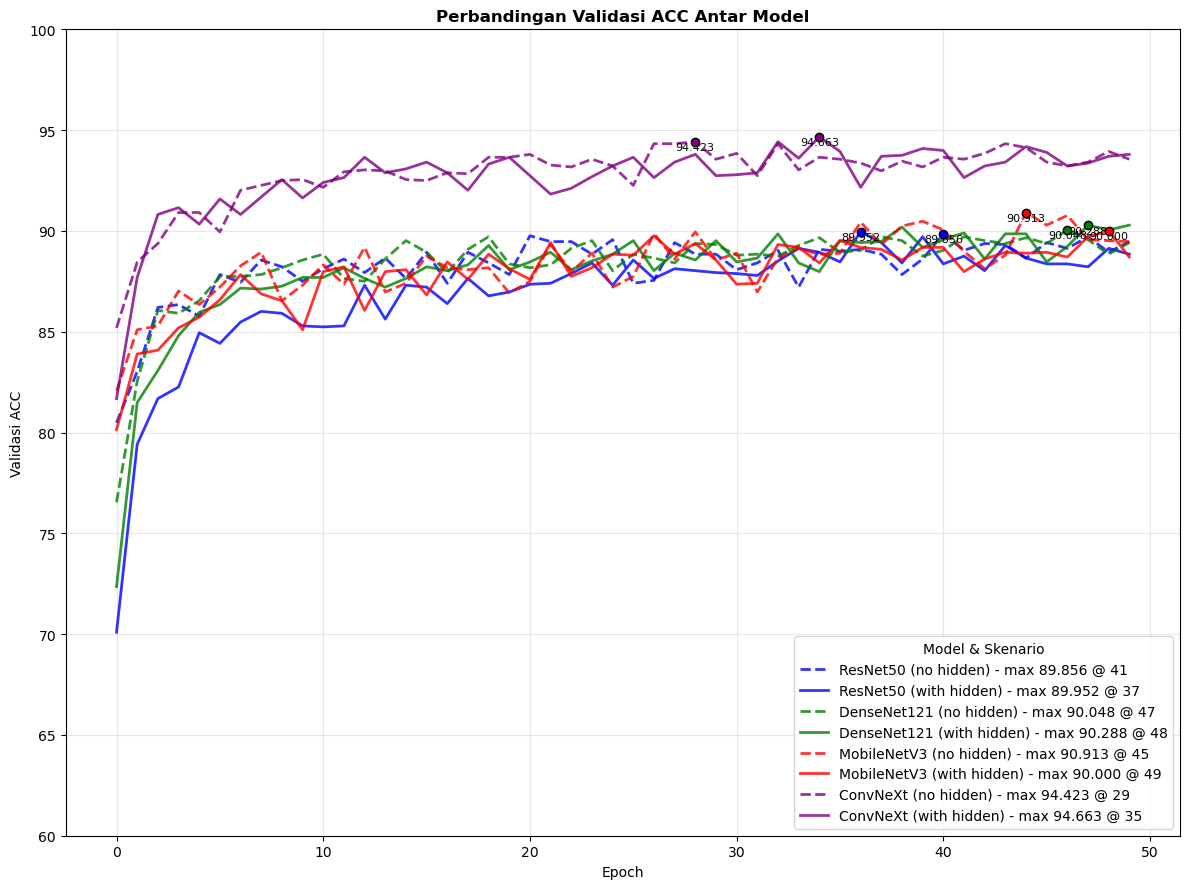

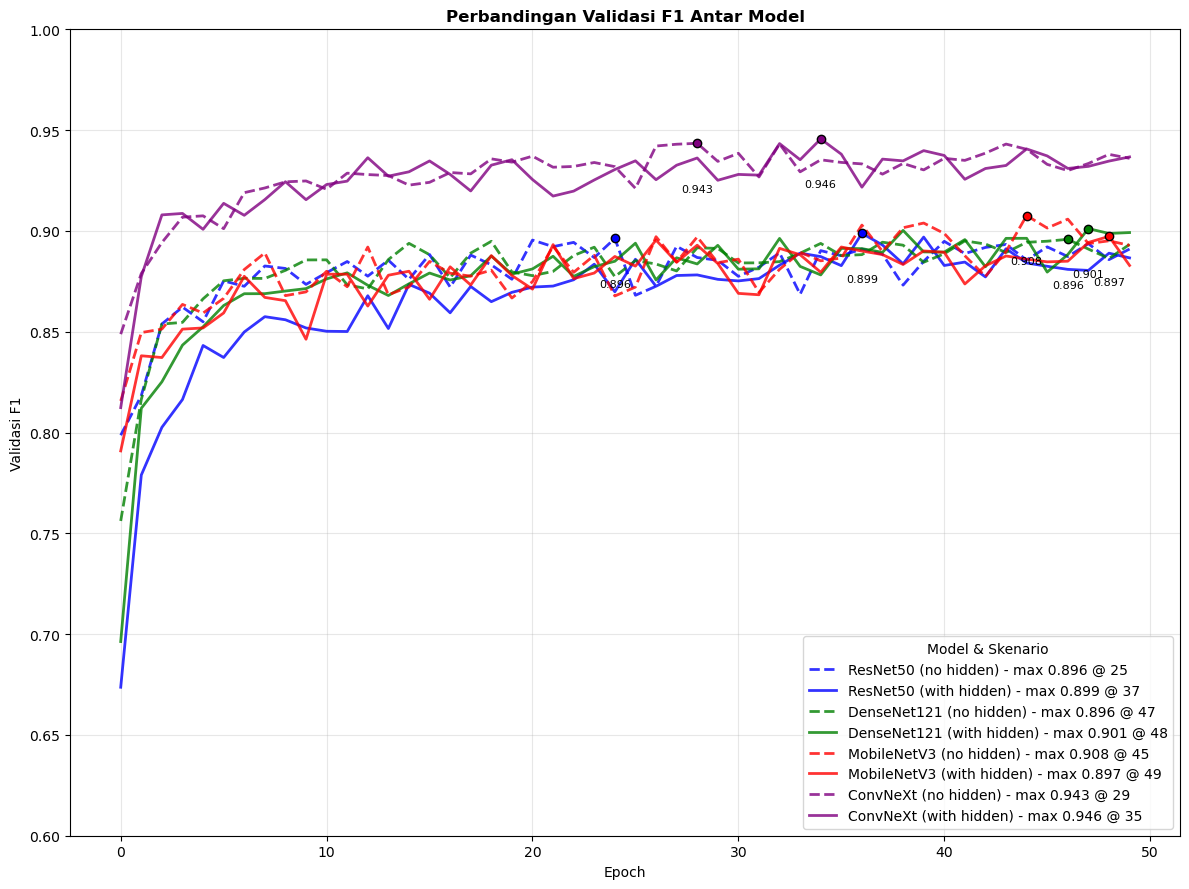

In [10]:
# Multi-Line Chart | Acc & F1 | Val
def plot_metric_comparison(results_training_df, metric='acc'):
    plt.figure(figsize=(12, 9))
    palette = {
        'ResNet50': 'blue',
        'DenseNet121': 'green',
        'MobileNetV3': 'red',
        'ConvNeXt': 'purple'
    }

    styles = {
        'no_hidden': 'dashed',
        'with_hidden': 'solid'
    }

    legend_items = []

    for model in results_training_df['model_name'].unique():
        for scenario in ['no_hidden', 'with_hidden']:
            subset = results_training_df[
                (results_training_df['model_name'] == model) & (results_training_df['scenario'] == scenario)
            ]
            if not subset.empty:
                history = subset.iloc[0]['history']
                val_metric = history[f'val_{metric}']
                best_epoch = max(range(len(val_metric)), key=lambda i: val_metric[i])
                best_value = val_metric[best_epoch]

                label = f"{model} ({scenario.replace('_', ' ')}) - max {best_value:.3f} @ {best_epoch+1}"
                legend_items.append(label)

                plt.plot(
                    val_metric, 
                    linestyle=styles[scenario],
                    color=palette[model],
                    linewidth=2,
                    alpha=0.8,
                    label=label
                )

                # Mark the best point
                plt.scatter(
                    best_epoch, best_value,
                    color=palette[model],
                    edgecolor='black',
                    zorder=5
                )

                # Add value text
                plt.text(
                    best_epoch, best_value - 0.02,
                    f"{best_value:.3f}",
                    ha='center',
                    va='top',
                    fontsize=8,
                    color='black'
                )

    plt.title(f'Perbandingan Validasi {metric.upper()} Antar Model', weight='bold')
    plt.xlabel('Epoch')
    plt.ylabel(f'Validasi {metric.upper()}')
    if max(val_metric) > 1.0:
        plt.ylim(60, 100)
    else :
        plt.ylim(0.6, 1)
    plt.grid(True, alpha=0.3)
    plt.legend(title="Model & Skenario", loc='lower right', frameon=True)
    plt.tight_layout()
    plt.savefig(f'C:/Users/ASUS/Coding/Jupiter/PRTA/val_{metric}_comparison.png', bbox_inches='tight')
    plt.show()

# Plot untuk akurasi
plot_metric_comparison(results_training_df, metric='acc')

# Plot untuk F1-score
plot_metric_comparison(results_training_df, metric='f1')

In [11]:
# Fungsi Waktu Komputasi
import os
from PIL import Image

def load_model_for_inference(model_name, scenario, model_dir='C:/Users/ASUS/Coding/Jupiter/PRTA/'):
    model = initialize_model(model_name, scenario)
    model_path = f'{model_dir}{model_name}_{scenario}.pth'
    model.load_state_dict(torch.load(model_path, map_location=device))
    return model.eval()


def get_random_images(folder, num_samples):
    all_paths = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith('.jpg'):
                all_paths.append(os.path.join(root, file))
    return random.sample(all_paths, min(num_samples, len(all_paths)))


def compute_time(model, image_paths, model_name, scenario):
    results = []
    transform = data_transforms['val']

    # Warm-up
    warmup_image = Image.open(image_paths[0]).convert('RGB')
    warmup_tensor = transform(warmup_image).unsqueeze(0).to(device)

    for _ in range(3):
        with torch.no_grad():
            _ = model(warmup_tensor)
        torch.cuda.synchronize()

    for path in image_paths:
        image = Image.open(path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Measurement
        start_time = time.time()
        with torch.no_grad():
            _ = model(input_tensor)
        end_time = time.time()

        duration = end_time - start_time
        results.append({
            'model': model_name,
            'scenario': scenario,
            'image_path': path,
            'compute_time_sec': duration
        })
    return results

In [12]:
# compute time all models
model_names = ['ResNet50', 'DenseNet121', 'MobileNetV3', 'ConvNeXt']
scenarios = ['no_hidden', 'with_hidden']

results_inference = []
image_paths = get_random_images(val_dir, 100)

for model_name in model_names:
    for scenario in scenarios:
        print(f'Measuring compute time for {model_name} | {scenario} ...')
        model_inference = load_model_for_inference(model_name, scenario)
        inference_results = compute_time(model_inference, image_paths, model_name, scenario)
        results_inference.extend(inference_results)

# Simpan hasil
results_inference_df = pd.DataFrame(results_inference)
results_inference_df.to_csv('C:/Users/ASUS/Coding/Jupiter/PRTA/compute_times.csv', index=False)

# Menampilkan hasil
summary = results_inference_df.groupby(['model', 'scenario'])['compute_time_sec'].agg(['mean', 'sum']).reset_index()
summary = summary.rename(columns={'mean': 'avg_time_sec', 'sum': 'total_time_sec'})
print("\n Rangkuman Waktu komputasi per Model:")
print(summary)

Measuring compute time for ResNet50 | no_hidden ...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13472\3000420212.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=dev

Measuring compute time for ResNet50 | with_hidden ...
Measuring compute time for DenseNet121 | no_hidden ...
Measuring compute time for DenseNet121 | with_hidden ...
Measuring compute time for MobileNetV3 | no_hidden ...
Measuring compute time for MobileNetV3 | with_hidden ...
Measuring compute time for ConvNeXt | no_hidden ...
Measuring compute time for ConvNeXt | with_hidden ...

 Rangkuman Waktu komputasi per Model:
         model     scenario  avg_time_sec  total_time_sec
0     ConvNeXt    no_hidden      0.010299        1.029889
1     ConvNeXt  with_hidden      0.009814        0.981376
2  DenseNet121    no_hidden      0.032242        3.224161
3  DenseNet121  with_hidden      0.033547        3.354680
4  MobileNetV3    no_hidden      0.014409        1.440868
5  MobileNetV3  with_hidden      0.012843        1.284342
6     ResNet50    no_hidden      0.016321        1.632056
7     ResNet50  with_hidden      0.012274        1.227438


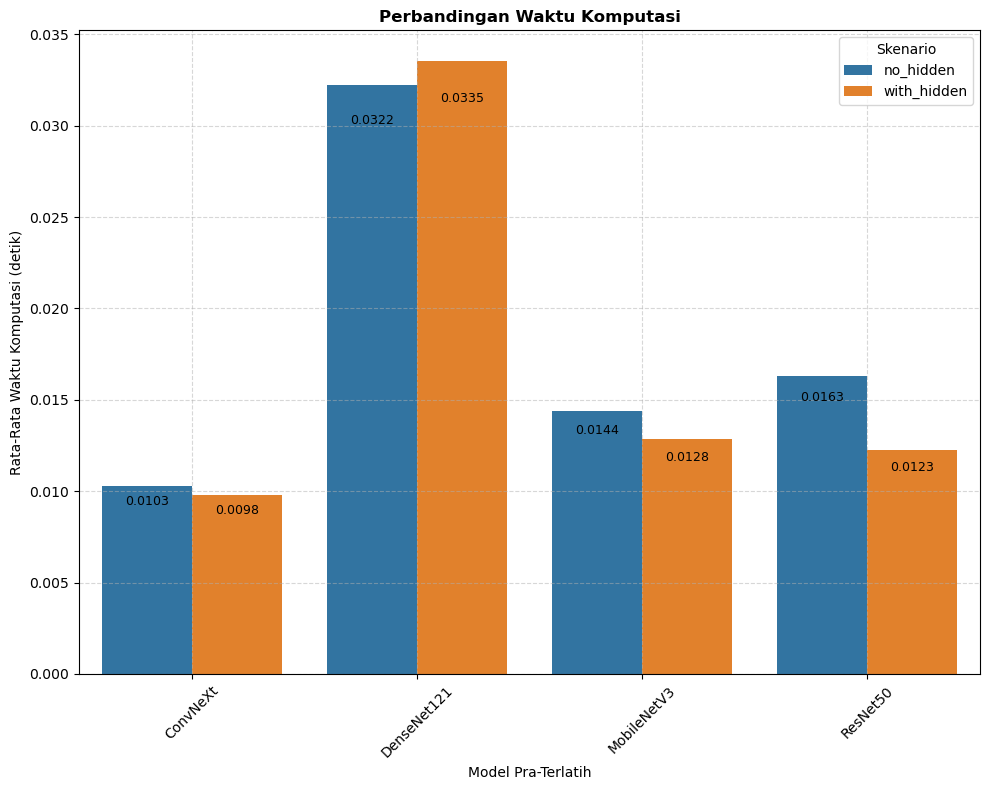

In [13]:
# Barplot Waktu Komputasi
csv_path = 'C:/Users/ASUS/Coding/Jupiter/PRTA/compute_times.csv'
time_df = pd.read_csv(csv_path)

# Hitung rata-rata waktu inferensi untuk setiap kombinasi model-skenario
mean_times = time_df.groupby(['model', 'scenario'])['compute_time_sec'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 8))
bpwk = sns.barplot(
    data=mean_times,
    x='model',
    y='compute_time_sec',
    hue='scenario'
)

for p in bpwk.patches:
    height = p.get_height()
    bpwk.annotate(
        f'{height:.4f}',
        (p.get_x() + p.get_width() / 2., height - (height * 0.05)),
        ha='center', va='top',
        fontsize=9,
        color='black'
    )

plt.title('Perbandingan Waktu Komputasi', weight='bold')
plt.xlabel('Model Pra-Terlatih')
plt.ylabel('Rata-Rata Waktu Komputasi (detik)')
plt.legend(title='Skenario',loc='upper right', frameon=True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('C:/Users/ASUS/Coding/Jupiter/PRTA/Compute_times.png')
plt.show()

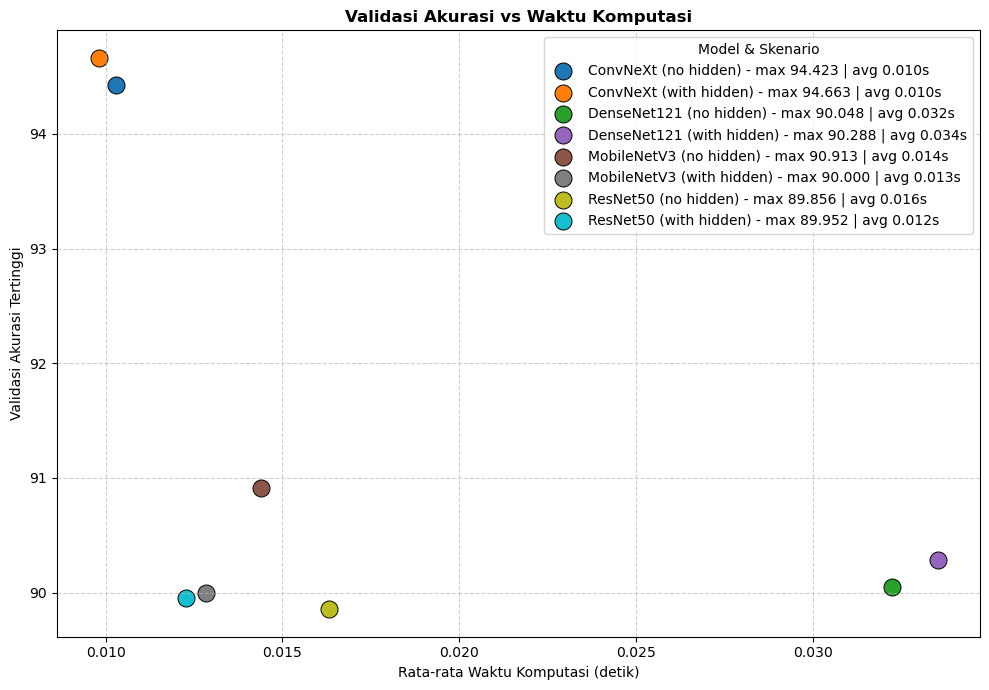

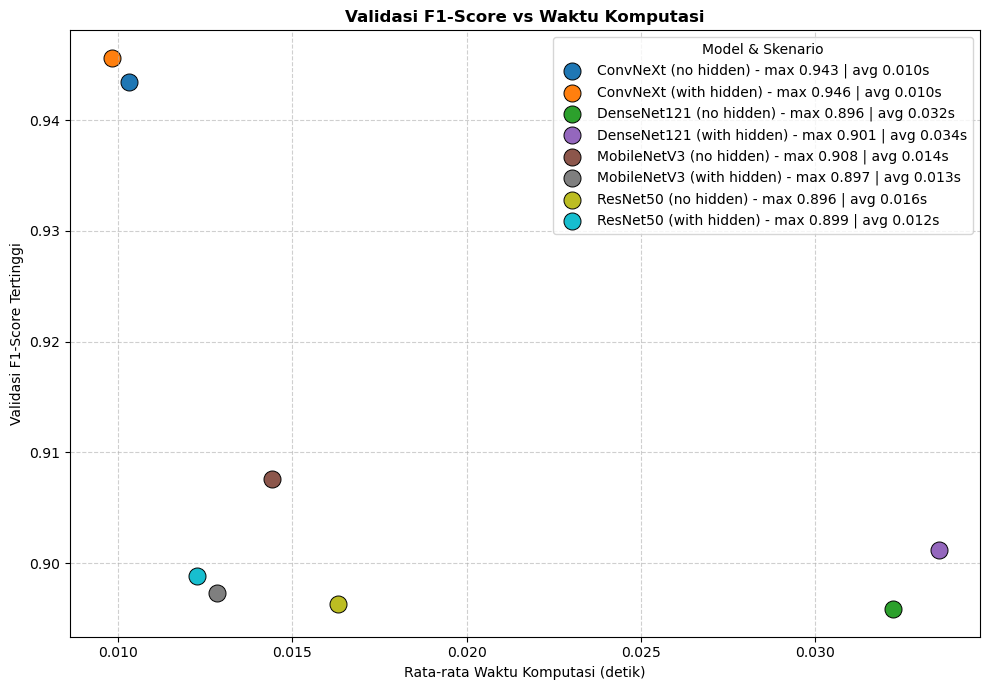

In [14]:
# Menentukan Model Optimal
import ast
path = 'C:/Users/ASUS/Coding/Jupiter/PRTA/train&val_results.csv'
training_df = pd.read_csv(path)

def extract_best_val_metric(history_str, metric='acc'):
        try:
            history = ast.literal_eval(history_str)
            val_metric = history.get(f'val_{metric}', [])
            if val_metric:
                return max(val_metric)
        except Exception:
            return None
        return None

def plot_metric_vs_time(training_df, time_df, metric='acc', save_path='C:/Users/ASUS/Coding/Jupiter/PRTA'):
    # === 1. Ekstraksi nilai terbaik untuk metrik tertentu ===
    training_df[f'best_val_{metric}'] = training_df['history'].apply(lambda x: extract_best_val_metric(x, metric))
    metric_summary = (
        training_df.groupby(['model_name', 'scenario'])[f'best_val_{metric}'].max().reset_index()
    )

    # === 2. Hitung rata-rata waktu per model & skenario ===
    time_summary = (
        time_df.groupby(['model', 'scenario'])['compute_time_sec'].mean().reset_index()
    )

    # === 3. Gabungkan hasil ===
    merged = pd.merge(
        metric_summary,
        time_summary,
        left_on=['model_name', 'scenario'],
        right_on=['model', 'scenario']
    )

    # === 4. Plot Scatter ===
    plt.figure(figsize=(10, 7))
    colors = plt.cm.tab10(np.linspace(0, 1, len(merged)))

    for i, row in merged.iterrows():
        model = row['model_name']
        scenario = row['scenario']
        metric_val = row[f'best_val_{metric}']
        time_val = row['compute_time_sec']
        color = colors[i]

        # Label legenda
        label = (
            f"{model} ({scenario.replace('_', ' ')}) "
            f"- max {metric_val:.3f} | avg {time_val:.3f}s"
        )

        plt.scatter(
            time_val,
            metric_val,
            color=color,
            s=150,
            label=label,
            edgecolor='black',
            linewidth=0.7
        )

    # === 5. Pengaturan tampilan ===
    metric_label = 'Akurasi' if metric == 'acc' else 'F1-Score'
    plt.title(f"Validasi {metric_label} vs Waktu Komputasi",  weight='bold')
    plt.xlabel("Rata-rata Waktu Komputasi (detik)")
    plt.ylabel(f"Validasi {metric_label} Tertinggi")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title="Model & Skenario", loc='upper right', frameon=True)
    plt.tight_layout()

    # === 6. Simpan dan tampilkan ===
    file_path = f"{save_path}/comptime_vs_val_{metric}.png"
    plt.savefig(file_path, bbox_inches='tight')
    plt.show()
    
plot_metric_vs_time(training_df, time_df, metric='acc')
plot_metric_vs_time(training_df, time_df, metric='f1')